## 导入依赖

In [1]:
import os
import copy
import numpy as np
import cv2
import open3d as o3d
from matplotlib import pyplot as plt
# 阿凯机器人工具箱
from kyle_robot_toolbox.yolov8 import YoloV8Segment
from kyle_robot_toolbox.camera import Gemini335
from kyle_robot_toolbox.open3d import *
from kyle_robot_toolbox.transform import *
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


pybullet build time: May 20 2022 19:44:17


## 载入模型

In [2]:
# 模型路径
model_path = os.path.join(os.path.abspath("."), "weights", "color_block_yolov8seg.pt")
# 载入实例分割模型(使用绝对路径)
model = YoloV8Segment(model_path)

## 创建相机对象

In [3]:
# 创建相机对象
camera = Gemini335()

[I20230506 13:57:43.264832 11556 Context.cpp:13] Context creating!
[I20230506 13:57:43.265034 11556 Context.cpp:78] filter version[major.minor.maintenance.build]: 1.1.4.0
[I20230506 13:57:43.265065 11556 DeviceManager.cpp:54] DeviceManager init ...
[I20230506 13:57:43.265401 11556 LinuxPal.cpp:21] createObPal: create LinuxPal!
[I20230506 13:57:43.338670 11556 EnumeratorLibusb.cpp:325] queryDevicesInfo done!
[I20230506 13:57:43.339079 11556 DeviceManager.cpp:373] Current usb device port list::
[I20230506 13:57:43.339089 11556 DeviceManager.cpp:375]         - 2-5.4.1-6.0 | Orbbec Gemini 2 Depth Camera
[I20230506 13:57:43.339114 11556 DeviceManager.cpp:375]         - 2-5.4.1-6.2 | Orbbec Gemini 2 IR Camera
[I20230506 13:57:43.339119 11556 DeviceManager.cpp:375]         - 2-5.4.1-6.4 | Orbbec Gemini 2 RGB Camera
[I20230506 13:57:43.339123 11556 DeviceManager.cpp:375]         - 2-5.4.1-6.6 | Orbbec Gemini Data Channel
[I20230506 13:57:43.339128 11556 DeviceManager.cpp:375]         - 2-5.4.1

## 采集图像

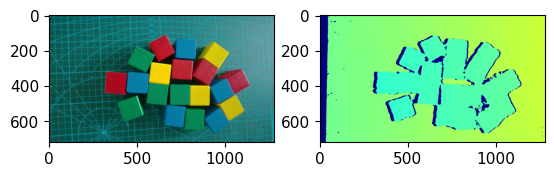

In [4]:
color_img, depth_img = camera.read()
depth_canvas = camera.depth_img2canvas(depth_img)
plt.subplot(1, 2, 1)
plt.imshow(color_img[:, :, ::-1])
plt.subplot(1, 2, 2)
plt.imshow(depth_canvas[:, :, ::-1])

In [5]:
# 原始点云
pcd_scene = camera.get_pcd(color_img, depth_img)
draw_geometry([pcd_scene])

## 模型预测


0: 640x1088 19 color_blocks, 35.1ms
Speed: 5.9ms preprocess, 35.1ms inference, 3.5ms postprocess per image at shape (1, 3, 1088, 1088)


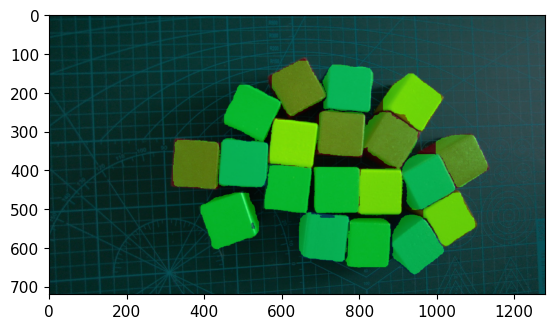

In [6]:
result = model.segment(color_img)
canvas, class_id_list, obj_mask_list, xyxy_list, conf_list = result 
plt.imshow(canvas[:, :, ::-1])

物体类别ID列表: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ROI区域: [859, 151, 1013, 300]
置信度: 0.967


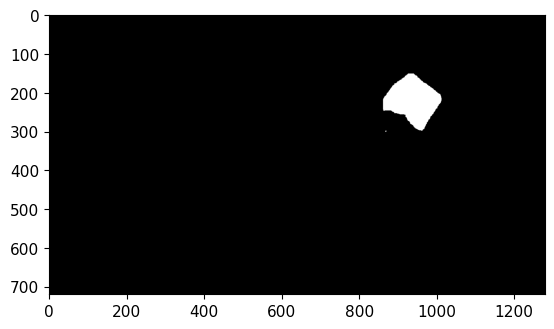

In [7]:
obj_idx = 0
print(f"物体类别ID列表: {class_id_list}")
print(f"ROI区域: {xyxy_list[obj_idx]}")
print(f"置信度: {conf_list[obj_idx]:.3f}")
# 显示物体的Mask
mask = obj_mask_list[obj_idx]
plt.imshow(mask, cmap="gray")

## 获取实例点云

In [8]:
obj_pcd_list = []
for mask in obj_mask_list:
    obj_pcd = camera.get_pcd(color_img, depth_img, mask=mask)
    obj_pcd.paint_uniform_color([np.random.rand() for i in range(3)])
    obj_pcd_list.append(obj_pcd)

In [11]:
# 展示其中一个实例点云
draw_geometry([obj_pcd_list[0]])

## 移除噪声

In [19]:
obj_pcd = obj_pcd_list[0]
# 移除离群点
cl, ind = obj_pcd.remove_statistical_outlier(nb_neighbors=20,
                                        std_ratio=0.1)
# 展示离群点
display_inlier_outlier(obj_pcd, ind)
# 筛选点云
obj_pcd_filter = obj_pcd.select_by_index(ind)
draw_geometry([obj_pcd_filter], window_name="移除离群点后的上表面点云")

In [23]:
obj_pcd_list_filter = []
for obj_pcd in obj_pcd_list:
    # 移除离群点
    cl, ind = obj_pcd.remove_statistical_outlier(nb_neighbors=10,
                                            std_ratio=0.2)
    # 展示离群点
    # display_inlier_outlier(obj_pcd, ind)
    # 筛选点云
    obj_pcd_filter = obj_pcd.select_by_index(ind)
    obj_pcd_list_filter.append(obj_pcd_filter)

## 可视化

In [24]:
# 展示所有实例的点云
pcd_scene_copy = copy.deepcopy(pcd_scene)
pcd_scene_copy.transform(Transform.dzmat(+0.001))
draw_geometry([pcd_scene_copy] + obj_pcd_list_filter)